In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
# Use the file with embedding features
FEATURES_PREPPED_FILE = "features_prepped_with_neighbors.csv"
TRAIN_TEST_SPLIT = 0.9
VAL_TEST_SPLIT = 0.9
START_DATE = datetime(2025,9,8) + timedelta(days=28)
BAD_FEATURES = []
TOP_100 = [2637208, 2674067, 2674069, 2677746, 2691590, 2739813, 2813189, 2813194, 2813195, 2819449, 2822887, 2840431, 2841189, 2855586, 2855595, 2857178, 3690505, 3690510, 4039724, 4189521, 4463773, 4580598, 5192206, 5192221, 5192225, 5245545, 5257669, 5658823, 5664444, 5683132, 5683135, 5683137, 5698506, 5698507, 5703921, 5710675, 5730396, 5823149, 5823150, 5850773, 5851707, 5955504, 5955510, 5955515, 5973485, 6049412, 6049413, 6256793, 6451779, 7210406, 7249979, 7379752, 7622814, 7622840, 7635753, 7653413, 7855462, 7869313, 7915951, 7917434, 7917436, 7922326, 8152638, 8152776, 8152803, 8152804, 8217944, 8422222, 8596633, 8858060, 8880222, 8966982, 8971859, 8972128, 9209729, 9245542, 9256674, 9603028, 9603030, 9603032, 9603035, 9656727, 9680118, 9724035, 10041062, 10041066, 10648067, 11061680, 11562016, 11562019, 12120522, 12168743, 12376820, 12376825, 12681178, 12744603, 13419273, 13536691, 14158330, 14234253]

In [ ]:
df = pd.read_csv(FEATURES_PREPPED_FILE)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(by='date')
df = df[df['date'] >= START_DATE]
df

,universal_gemrate_id,spec_id,date,price,grade,half_grade,number_of_bids,grade_co_BGS,grade_co_CGC,grade_co_PSA,...,neighbor_1_avg_price,neighbor_1_similarity,neighbor_2_avg_price,neighbor_2_similarity,neighbor_3_avg_price,neighbor_3_similarity,neighbor_4_avg_price,neighbor_4_similarity,neighbor_5_avg_price,neighbor_5_similarity
217175,d3a98a5025ba546611d71c2ac6c0835128be1ae8,8434025,2025-09-01,8.594154,9.0,0.0,20,0,0,1,...,8.594154,0.996175,8.476371,0.995536,8.456449,0.995379,8.935817,0.994877,8.866081,0.994758
181984,ab9848fd2d1d74212b8a99548660d958109fc383,5245520,2025-09-01,9.550378,1.0,0.0,30,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8045,09c080cf6d61b9e67610c8b1cfe26c3c0c3f64d6,12168743,2025-09-01,10.305614,9.0,0.0,13,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217812,d47a8bf18db5d3f406419c9c597a7797c50449b6,1776897,2025-09-01,10.933107,8.0,0.0,43,0,0,1,...,11.755872,0.995583,10.933107,0.995111,NaN,NaN,NaN,NaN,NaN,NaN
190340,b54e7c70952545b8b49dd5b47d6129f876fb4a36,6451794,2025-09-01,7.313887,9.0,0.0,9,0,0,1,...,7.408531,0.985162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48196,2618f36ec1473935d60380a8de67be9c4b20eed8,544047,2025-12-17,8.039157,4.0,0.0,5,0,0,1,...,5.991465,0.994006,7.951212,0.991248,7.921500,0.990275,9.096765,0.988574,7.901007,0.988434
53820,2cc49de9ef33d0710167f1c1e3b8b11107a5f055,9875042,2025-12-17,9.314971,10.0,0.0,14,0,0,1,...,7.765375,0.992243,8.825220,0.989694,9.450389,0.989401,9.071078,0.988925,NaN,NaN
51064,298669bd9e8b6ba3c10fde17edc1e46223a8be83,544484,2025-12-17,9.592196,10.0,0.0,28,0,1,0,...,8.999619,0.985703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54711,2de168406c7c8944d9c321ce84dbd2be7a64f6cd,544167,2025-12-17,8.294050,8.0,0.0,23,0,1,0,...,9.495520,0.990597,9.984010,0.990442,8.867850,0.989711,8.750683,0.989436,NaN,NaN


In [4]:
feature_cols = [col for col in df.columns if col not in ['universal_gemrate_id', 'spec_id', 'date', 'price'] and col not in BAD_FEATURES]
print(f"Total features: {len(feature_cols)}")

Total features: 147


In [5]:
train_df = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT)]
test_df = df.iloc[int(len(df) * TRAIN_TEST_SPLIT):]
val_df = test_df.iloc[:int(len(test_df) * VAL_TEST_SPLIT)]
test_df = test_df.iloc[int(len(test_df) * VAL_TEST_SPLIT):]

# val_df = val_df.loc[val_df["prev_1_price"].isna()]
# val_df = val_df.dropna(subset=['neighbor_1_avg_price'])
# test_df = test_df.loc[test_df["prev_1_price"].isna()]
# test_df = test_df.dropna(subset=['emb_neighbor_1_price'])
# val_df = val_df.loc[val_df["spec_id"].isin(TOP_100)]
# test_df = test_df.loc[test_df["spec_id"].isin(TOP_100)]
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
val_df["date"].min()

Train: 242153, Val: 24215, Test: 2691


Timestamp('2025-11-26 00:00:00')

In [6]:
X_train = train_df[feature_cols].copy()
y_train = train_df['price'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['price'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['price'].copy()

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {len(feature_cols)}")

Training set: 242153 samples
Validation set: 24215 samples
Test set: 2691 samples
Number of features: 147


In [7]:
model = XGBRegressor(device='cuda')

# Define parameter grid
param_grid = {
    'max_depth': [10],
    'learning_rate': [0.075],
    'n_estimators': [150],
    'min_child_weight': [30],
    'subsample': [0.9],
    'colsample_bytree': [1.0],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [5],
    'colsample_bylevel': [0.7],
    'max_delta_step': [0],
}

best_score = 99999
best_grid = {}
for g in ParameterGrid(param_grid):
    model.set_params(**g)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_val_pred = np.exp(y_val_pred)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)
    print(f"MAPE: {mape:.2%}")
    if mape < best_score:
        best_score = mape
        best_grid = g
    print(f"Best MAPE: {best_score:.2%}")

print("Best MAPE: %0.5f" % best_score)
print("Best Grid:", best_grid)

MAPE: 246237.04%
Best MAPE: 246237.04%
Best MAPE: 2462.37042
Best Grid: {'colsample_bylevel': 0.7, 'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.075, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 30, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.9}


/root/sync/ava/collector_crypt/.venv/lib/python3.13/site-packages/xgboost/core.py:774: UserWarning: [14:59:18] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [8]:
best_model = XGBRegressor(device='cuda')
best_model.set_params(**best_grid)
best_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.7
,colsample_bynode,None
,colsample_bytree,1.0
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [9]:
y_val = np.exp(y_val)
y_val_pred = best_model.predict(X_val)
y_val_pred = np.exp(y_val_pred)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

simple_percent_error = (np.abs(X_val["prev_1_price"].values - y_val.values) / y_val.values) * 100
simple_percent_error_series = pd.Series(simple_percent_error, name='simple_percent_error')
percent_error = (np.abs(y_val_pred - y_val.values) / y_val.values) * 100
percent_error_series = pd.Series(percent_error, name='percent_error')

print("Validation Metrics:")
print(f"  RMSE: ${val_rmse:,.2f}")
print(f"  MAE:  ${val_mae:,.2f}")
print(f"  MAPE: {val_mape:.2%}")
print(f"  R²:   {val_r2:.4f}")

print("\nSimple Percent Error Percentiles:")
print(simple_percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

print("\nPercent Error Percentiles:")
print(percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

Validation Metrics:
  RMSE: $45,767.41
  MAE:  $6,405.92
  MAPE: 21.84%
  R²:   0.7442

Simple Percent Error Percentiles:
count    22613.000000
mean        99.869080
std          0.146217
min         96.266314
10%         99.732450
20%         99.801462
30%         99.841526
40%         99.873597
50%         99.903026
60%         99.931867
70%         99.953746
80%         99.967371
90%         99.982998
max         99.999690
Name: simple_percent_error, dtype: float64

Percent Error Percentiles:
count    24215.000000
mean        21.843924
std        169.058774
min          0.000077
10%          2.121943
20%          4.226790
30%          6.483737
40%          9.150686
50%         12.249451
60%         15.954071
70%         20.927259
80%         28.726354
90%         43.414124
max      23176.539008
Name: percent_error, dtype: float64


In [10]:
y_test = np.exp(y_test)
y_test_pred = best_model.predict(X_test)
y_test_pred = np.exp(y_test_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

simple_percent_error = (np.abs(X_test["prev_1_price"].values - y_test.values) / y_test.values) * 100
simple_percent_error_series = pd.Series(simple_percent_error, name='simple_percent_error')
percent_error = (np.abs(y_test_pred - y_test.values) / y_test.values) * 100
percent_error_series = pd.Series(percent_error, name='percent_error')

print("Test Metrics:")
print(f"  RMSE: ${test_rmse:,.2f}")
print(f"  MAE:  ${test_mae:,.2f}")
print(f"  MAPE: {test_mape:.2%}")
print(f"  R²:   {test_r2:.4f}")

print("\nSimple Percent Error Percentiles:")
print(simple_percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

print("\nPercent Error Percentiles:")
print(percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

Test Metrics:
  RMSE: $23,029.59
  MAE:  $5,133.93
  MAPE: 20.62%
  R²:   0.9063

Simple Percent Error Percentiles:
count    2522.000000
mean       99.870373
std         0.163232
min        96.294222
10%        99.735464
20%        99.798970
30%        99.838614
40%        99.876858
50%        99.913193
60%        99.936725
70%        99.953982
80%        99.967253
90%        99.981074
max        99.998928
Name: simple_percent_error, dtype: float64

Percent Error Percentiles:
count    2691.000000
mean       20.624344
std        29.661475
min         0.010721
10%         1.972864
20%         4.175654
30%         6.761570
40%         9.397865
50%        12.639077
60%        16.730305
70%        21.616324
80%        29.947081
90%        44.593937
max       592.786230
Name: percent_error, dtype: float64


In [11]:
y_test

125335    25500.0
125334    24750.0
125200    13750.0
224466     8300.0
224467     8200.0
           ...   
48196      3100.0
53820     11103.0
51064     14650.0
54711      4000.0
76091     29700.0
Name: price, Length: 2691, dtype: float64

In [12]:
y_test_pred

array([25157.172 , 26017.678 ,  9832.711 , ..., 15729.8545,  6394.4307,
       11064.738 ], shape=(2691,), dtype=float32)

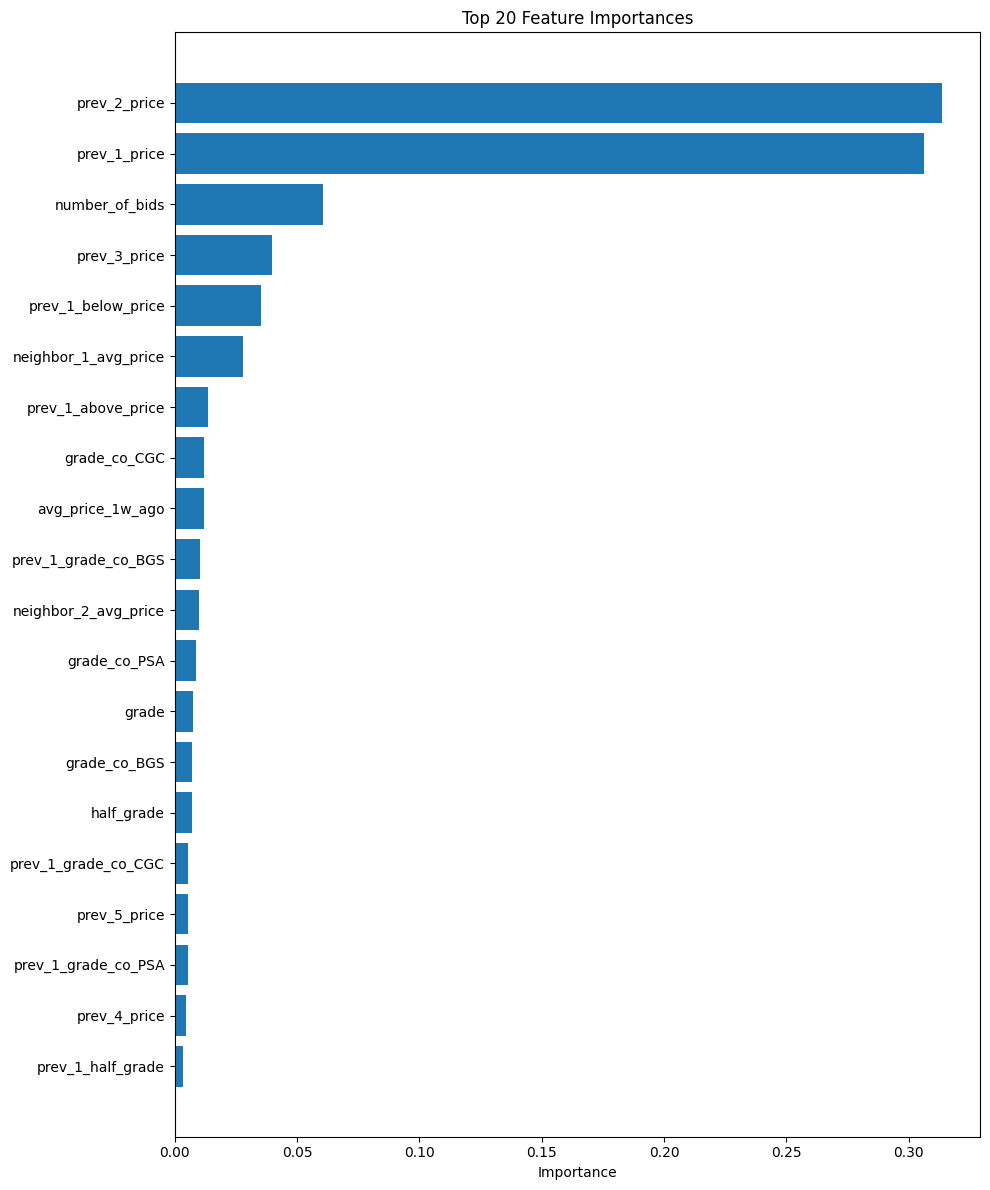

,feature,importance
14,prev_2_price,0.313524
8,prev_1_price,0.306486
2,number_of_bids,0.060657
20,prev_3_price,0.039647
97,prev_1_below_price,0.035122
137,neighbor_1_avg_price,0.027799
62,prev_1_above_price,0.013778
4,grade_co_CGC,0.012096
38,avg_price_1w_ago,0.012020
10,prev_1_grade_co_BGS,0.010167


In [13]:
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importance_df.head(20)

In [14]:
importance_df["importance_cumsum"] = importance_df["importance"].cumsum()
importance_df

,feature,importance,importance_cumsum
14,prev_2_price,0.313524,0.313524
8,prev_1_price,0.306486,0.620010
2,number_of_bids,0.060657,0.680668
20,prev_3_price,0.039647,0.720315
97,prev_1_below_price,0.035122,0.755437
...,...,...,...
123,prev_4_below_seller_popularity,0.000360,0.998980
116,prev_3_below_seller_popularity,0.000357,0.999337
94,prev_5_above_grade_co_PSA,0.000347,0.999684
71,prev_2_above_grade_co_BGS,0.000316,1.000000


In [15]:
bad_features = importance_df[importance_df["importance_cumsum"] > 0.95]["feature"]
list(bad_features)

['avg_price_4w_ago',
 'prev_2_half_grade',
 'avg_grade_co_CGC_1w_ago',
 'prev_4_above_price',
 'prev_3_above_price',
 'prev_1_below_days_ago',
 'prev_5_grade_co_PSA',
 'neighbor_2_similarity',
 'prev_5_above_price',
 'prev_5_grade_co_CGC',
 'prev_5_half_grade',
 'prev_3_half_grade',
 'prev_4_grade_co_PSA',
 'prev_2_above_grade_co_CGC',
 'avg_grade_co_PSA_1w_ago',
 'prev_3_grade_co_BGS',
 'prev_5_grade_co_BGS',
 'prev_4_grade_co_BGS',
 'avg_grade_co_CGC_4w_ago',
 'prev_5_above_grade_co_BGS',
 'prev_4_below_half_grade',
 'neighbor_4_similarity',
 'neighbor_3_similarity',
 'prev_2_below_grade_co_BGS',
 'prev_3_above_grade_co_CGC',
 'prev_5_below_grade_co_PSA',
 'neighbor_5_similarity',
 'prev_3_above_days_ago',
 'prev_2_below_grade_co_PSA',
 'prev_4_below_days_ago',
 'prev_3_above_grade_co_BGS',
 'prev_2_above_half_grade',
 'prev_2_above_days_ago',
 'prev_4_half_grade',
 'prev_4_above_days_ago',
 'prev_5_below_days_ago',
 'prev_4_below_grade_co_PSA',
 'avg_grade_co_CGC_2w_ago',
 'prev_5_b

## Prediction Intervals with Quantile Regression

Train additional XGBoost models to predict lower and upper bounds using quantile regression.
This provides uncertainty estimates for each prediction.

In [16]:
# Train quantile regression models for prediction intervals
# Lower bound (10th percentile) and upper bound (90th percentile)

LOWER_QUANTILE = 0.1
UPPER_QUANTILE = 0.9

# Create quantile regression models using the same hyperparameters as the best model
quantile_params = best_grid.copy()

# Train lower bound model
model_lower = XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=LOWER_QUANTILE,
    device='cuda',
    **quantile_params
)
model_lower.fit(X_train, y_train)
print(f"Lower bound model (q={LOWER_QUANTILE}) trained")

# Train upper bound model
model_upper = XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=UPPER_QUANTILE,
    device='cuda',
    **quantile_params
)
model_upper.fit(X_train, y_train)
print(f"Upper bound model (q={UPPER_QUANTILE}) trained")

Lower bound model (q=0.1) trained
Upper bound model (q=0.9) trained


In [17]:
# Generate prediction intervals for test set
y_test_pred_lower = np.exp(model_lower.predict(X_test))
y_test_pred_upper = np.exp(model_upper.predict(X_test))
y_test_pred_median = y_test_pred  # Use point prediction as median

# Calculate interval coverage (percentage of actual values within predicted interval)
in_interval = (y_test.values >= y_test_pred_lower) & (y_test.values <= y_test_pred_upper)
coverage = in_interval.mean()

# Calculate average interval width
interval_width = y_test_pred_upper - y_test_pred_lower
avg_interval_width = interval_width.mean()
relative_interval_width = (interval_width / y_test_pred_median).mean()

print(f"\nPrediction Interval Metrics (Test Set):")
print(f"  Target Coverage: {(UPPER_QUANTILE - LOWER_QUANTILE) * 100:.0f}%")
print(f"  Actual Coverage: {coverage * 100:.1f}%")
print(f"  Average Interval Width: ${avg_interval_width:,.2f}")
print(f"  Relative Interval Width: {relative_interval_width * 100:.1f}% of predicted price")


Prediction Interval Metrics (Test Set):
  Target Coverage: 80%
  Actual Coverage: 79.9%
  Average Interval Width: $16,203.32
  Relative Interval Width: 68.5% of predicted price


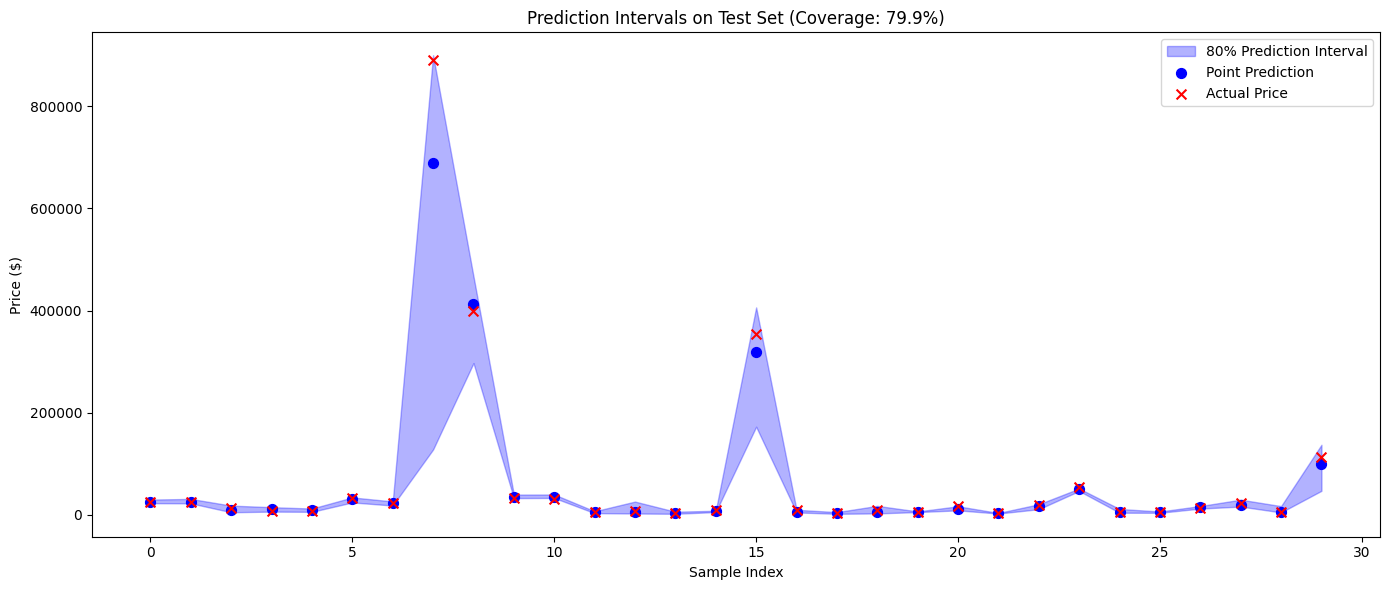

In [18]:
# Visualize prediction intervals for a sample of test predictions
n_samples = min(30, len(y_test))
sample_indices = np.arange(n_samples)

plt.figure(figsize=(14, 6))

# Plot prediction intervals
plt.fill_between(sample_indices, 
                 y_test_pred_lower[:n_samples], 
                 y_test_pred_upper[:n_samples], 
                 alpha=0.3, color='blue', label=f'{int((UPPER_QUANTILE-LOWER_QUANTILE)*100)}% Prediction Interval')

# Plot point predictions
plt.scatter(sample_indices, y_test_pred_median[:n_samples], 
            color='blue', s=50, zorder=3, label='Point Prediction')

# Plot actual values
plt.scatter(sample_indices, y_test.values[:n_samples], 
            color='red', s=50, marker='x', zorder=4, label='Actual Price')

plt.xlabel('Sample Index')
plt.ylabel('Price ($)')
plt.title(f'Prediction Intervals on Test Set (Coverage: {coverage*100:.1f}%)')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Create a summary DataFrame with predictions and intervals
predictions_df = pd.DataFrame({
    'actual_price': y_test.values,
    'predicted_price': y_test_pred_median,
    'lower_bound': y_test_pred_lower,
    'upper_bound': y_test_pred_upper,
    'interval_width': interval_width,
    'in_interval': in_interval
})

predictions_df['error'] = predictions_df['actual_price'] - predictions_df['predicted_price']
predictions_df['percent_error'] = (np.abs(predictions_df['error']) / predictions_df['actual_price']) * 100

print("\nPredictions with Intervals:")
predictions_df.head(15)


Predictions with Intervals:


,actual_price,predicted_price,lower_bound,upper_bound,interval_width,in_interval,error,percent_error
0,25500.0,25157.171875,22741.314453,29792.457031,7051.142578,True,342.828125,1.344424
1,24750.0,26017.677734,22446.767578,31101.451172,8654.683594,True,-1267.677734,5.121930
2,13750.0,9832.710938,4941.854980,17957.617188,13015.761719,True,3917.289063,28.489375
3,8300.0,10845.399414,6227.282227,14904.478516,8677.196289,True,-2545.399414,30.667463
4,8200.0,8718.156250,5801.642578,12244.898438,6443.255859,True,-518.156250,6.318979
5,33800.0,30099.890625,24200.199219,34011.109375,9810.910156,True,3700.109375,10.947069
6,22250.0,23100.011719,18104.382812,26168.978516,8064.595703,True,-850.011719,3.820277
7,890000.0,689782.625000,127949.367188,899951.625000,772002.250000,True,200217.375000,22.496334
8,400000.0,413051.593750,297071.312500,466889.656250,169818.343750,True,-13051.593750,3.262898
9,33000.0,35094.621094,32666.734375,39543.945312,6877.210938,True,-2094.621094,6.347337
